# Segmenting audio from the JAAH dataset

This notebook walks through the code to create a convolutional neural net (CNN) to classify audio frames from the JAAH dataset and use this information to segment the audio.

Most of the working parts are contained in a separate .py file, "deep_learning_utils.py". This notebook just calls those routines.

In [29]:
from deep_learning_utils import *

# Print multiple things in a single cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [30]:
# Three global variables were imported from deep_learning_utils:

# A DataFrame listing each song in the JAAH dataset and its audio path:
JAAH_INFO.head()
# A DataFrame listing each annotated "section" and parsed information about its label:
INFO_DF.head(10)
# The folder containing pre-computed audio features:
MY_BASE_PATH

,Unnamed: 0,stem,audio_path,audio_exists
0,0,swing_that_music,/Users/jordan/Documents/data/JAAH//Jazz_ The S...,True
1,1,wrap_your_troubles_in_dreams,/Users/jordan/Documents/data/JAAH//Jazz_ The S...,True
2,2,tricroism,/Users/jordan/Documents/data/JAAH//Jazz_ The S...,True
3,3,blues_for_alice,/Users/jordan/Documents/data/JAAH/Extra Songs/...,False
4,4,dinah,/Users/jordan/Documents/data/JAAH/SmithsonianC...,True


,part_name,ind,onset,offset,n_beats,words,instruments,inst_qualifiers,funcs,residual
0,head - abac,0,0.40,25.22,128,"[head, -, abac]",[],[],[head],[abac]
1,vocals male - abac,0,25.22,49.67,128,"[vocals, male, -, abac]",[vocals],[male],[],[abac]
2,ensemble - abac,0,49.67,74.37,128,"[ensemble, -, abac]",[ensemble],[],[],[abac]
3,trumpet solo - abac,0,74.37,97.86,128,"[trumpet, solo, -, abac]",[trumpet],[],[solo],[abac]
4,trumpet solo - abac,0,97.86,121.69,128,"[trumpet, solo, -, abac]",[trumpet],[],[solo],[abac]
5,trumpet solo - abac,0,121.69,145.62,128,"[trumpet, solo, -, abac]",[trumpet],[],[solo],[abac]
6,"trumpet solo, ensemble - abac",0,145.62,174.07,133,"[trumpet, solo, ensemble, -, abac]","[trumpet, ensemble]",[],[solo],[abac]
7,intro,1,1.34,8.97,16,[intro],[],[],[intro],[]
8,vocals female - aaba,1,8.97,69.54,128,"[vocals, female, -, aaba]",[vocals],[female],[],[aaba]
9,ensemble - coda,1,69.54,77.32,16,"[ensemble, -, coda]",[ensemble],[],[],[coda]


'/Users/jordan/Documents/data/JAAH/feature_data/'

In [31]:
# Define set of songs to analyse, and load pre-computed Mel-frequency spectrum frames.
MFSG_SONG_PATH_PATTERN = os.path.join(MY_BASE_PATH, 'jaah_song_%s_mfsg.npz')
audio_exists = JAAH_INFO.loc[JAAH_INFO.audio_exists].iloc[:,0].values
song_id_list = sorted(list(set.intersection(set(audio_exists), set(np.unique(INFO_DF.ind)))))

In [32]:
# This is where all the data gets loaded. It takes a while!
# It loads pre-computed mel-scale spectra for every song in the song_id_list.
# For each song, it loads percent_keep% of the spectra (selected randomly), and scrambles the order.
percent_keep = 0.05
images_proc_all, songvecs_all, onehots_all, metadata_columns = script_2_load_percent_of_all_info(song_id_list, 'instruments', percent_keep=percent_keep)

In [33]:
# The data where no instrument is "soloing" will still feature a prominent instrument,
# and we don't know what it is right now. So, let's remove them all from the training data:
solo_keep_inds = [i for i in range(other.shape[0]) if other[i]==0]
images_proc = images_proc_all[solo_keep_inds]
songvecs = songvecs_all[solo_keep_inds]
onehots = onehots_all[solo_keep_inds]

The song index this belongs to: 0.0
The i^th labels: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The instrument tags these correspond to: ['ensemble']


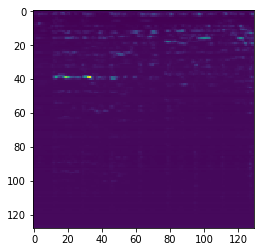

In [34]:
# Let's look at all the data we've loaded for a given spectrum.
i = 5
# The i^th spectrum:
plt.imshow(images_proc[i,:,:,0])
# The song index for that spectrum:
print("The song index this belongs to: {0}".format(songvecs[i]))
print("The i^th labels: {0}".format(onehots[i,:]))
print("The instrument tags these correspond to: {0}".format([metadata_columns[j] for j in range(onehots.shape[1]) if onehots[i,j]==1]))

In [35]:
# Define a smaller set of reasonable instrument categories:
# metadata_columns is: ['banjo', 'bass', 'clarinet', 'cornet', 'drums',
# 'ensemble', 'guitar', 'horn', 'piano', 'sax', 'scat', 'trombone', 'trumpet',
# 'vibraphone', 'vocals', 'no_instrument']
brass = np.sum(onehots[:,[metadata_columns.index(instr) for instr in ["trumpet", "trombone", "horn", "cornet"]]],axis=1)
reed = np.sum(onehots[:,[metadata_columns.index(instr) for instr in ["clarinet", "sax"]]],axis=1)
pluck = np.sum(onehots[:,[metadata_columns.index(instr) for instr in ["banjo", "guitar", "bass"]]],axis=1)
percussion = np.sum(onehots[:,[metadata_columns.index(instr) for instr in ["drums", "sax"]]],axis=1)
keyboard = np.sum(onehots[:,[metadata_columns.index(instr) for instr in ["piano", "vibraphone"]]],axis=1)
vocal = np.sum(onehots[:,[metadata_columns.index(instr) for instr in ["vocals", "scat"]]],axis=1)
other = np.sum(onehots[:,[metadata_columns.index(instr) for instr in ["ensemble","no_instrument"]]],axis=1)

In [36]:
# Define data splits:
input_shape = images_proc.shape[1:]
train_ranges, test_ranges, n_splits = produce_splits(song_id_list, 0.1)
print(n_splits)

10


# Create a single-label classifier

In [41]:
# Classes should be a one-hot matrix.
classes = np.stack((brass, 1-brass),axis=1)
n_classes = classes.shape[1]

In [43]:
# Create the classifier!
results_log = []
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems
optimizer = 'sgd' 
metrics = ['accuracy']
batch_size = 32
epochs = 5
# Performing this over many splits is recommended for proper evaluation.
# for split_i in range(n_splits):
for split_i in [3]:
    train_X, test_X, train_y, test_y = split_data_with_indices(images_proc, classes, songvecs, test_ranges[split_i])
    model = script_for_basic_model(input_shape, n_classes, n_layers=2)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs)
    test_pred = model.predict_classes(test_X)
    # test_pred[0:10]
    pred_split = np.sum(test_pred)/len(test_pred)
    # 1 layer
    acc = sklearn.metrics.accuracy_score(test_y[:,1], test_pred)
    # Baseline performance:
    baseline_acc = np.max(np.sum(classes,axis=0))/np.sum(classes)
    results_log += [[acc, baseline_acc, pred_split, history, model]]

Epoch 1/5
796/796 [==============================] - 14s 18ms/step - loss: 0.5125 - acc: 0.7845
Epoch 2/5
796/796 [==============================] - 13s 16ms/step - loss: 0.4546 - acc: 0.8241
Epoch 3/5
796/796 [==============================] - 14s 17ms/step - loss: 0.4395 - acc: 0.8247
Epoch 4/5
796/796 [==============================] - 13s 17ms/step - loss: 0.4287 - acc: 0.8241
Epoch 5/5
796/796 [==============================] - 14s 17ms/step - loss: 0.4177 - acc: 0.8304


In [56]:
result_i = 0
print("Achieved accuracy: {0}".format(results_log[result_i][0]))
print("Baseline accuracy: {0}".format(results_log[result_i][1]))
print("Frequency of dominant class: {0}".format(results_log[result_i][2]))

Achieved accuracy: 0.013888888888888888
Baseline accuracy: 0.22029488291413704
Frequency of dominant class: 5.680555555555555


In [ ]:
# Look at errors on the test set:


# Create a multi-label classifier

In [52]:
classes = np.stack((brass, reed, pluck, percussion, keyboard, vocal, other),axis=1)
n_classes = classes.shape[1]

In [58]:
# Create the classifier!
results_log = []
loss = 'binary_crossentropy' 
output_activation = 'sigmoid'
optimizer = 'sgd' 
metrics = ['accuracy']
batch_size = 32
epochs = 5
validation_split = 0.1
# Performing this over many splits is recommended for proper evaluation.
# for split_i in range(n_splits):
for split_i in [3]:
    train_X, test_X, train_y, test_y = split_data_with_indices(images_proc, classes, songvecs, test_ranges[split_i])
    model = script_for_basic_model(input_shape, n_classes, n_layers=2)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    test_pred = model.predict_classes(test_X)
    # test_pred[0:10]
    est_classes = {i:(np.count_nonzero(test_pred==i)) for i in range(max(test_pred)+1)}
    dom_freq = np.max(list(est_classes.values()))/len(test_pred)
    # 1 layer
    acc = sklearn.metrics.accuracy_score(test_y[:,1], test_pred)
    # Baseline performance:
    baseline_acc = np.max(np.sum(classes,axis=0))/np.sum(classes)
    results_log += [[acc, baseline_acc, dom_freq, history, model]]

Train on 716 samples, validate on 80 samples
Epoch 1/5
716/716 [==============================] - 13s 18ms/step - loss: 0.5262 - acc: 0.8111 - val_loss: 0.4896 - val_acc: 0.8179
Epoch 2/5
716/716 [==============================] - 17s 24ms/step - loss: 0.4871 - acc: 0.8130 - val_loss: 0.4659 - val_acc: 0.8179
Epoch 3/5
716/716 [==============================] - 17s 24ms/step - loss: 0.4710 - acc: 0.8128 - val_loss: 0.4554 - val_acc: 0.8179
Epoch 4/5
716/716 [==============================] - 18s 25ms/step - loss: 0.4626 - acc: 0.8128 - val_loss: 0.4502 - val_acc: 0.8179
Epoch 5/5
716/716 [==============================] - 13s 18ms/step - loss: 0.4573 - acc: 0.8132 - val_loss: 0.4471 - val_acc: 0.8179


In [59]:
result_i = 0
print("Achieved accuracy: {0}".format(results_log[result_i][0]))
print("Baseline accuracy: {0}".format(results_log[result_i][1]))
print("Frequency of dominant class: {0}".format(results_log[result_i][2]))

Achieved accuracy: 0.0
Baseline accuracy: 0.22029488291413704
Frequency of dominant class: 0.875
